## Filtering for Loci in Hardy-Weinberg Equilibrium

#### 5/8/2017 - 5/9/2017

<br>
### 1. created GENEPOP file 

In [1]:
cd ../scripts/

/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/scripts


In [6]:
!head genepop_conversion_forR.py

*I need to convert my tab-delimited file to genepop. I did this manually in text editor. *

I also edited the script text to include all of my populations with the appropriate column indices

In [9]:
!python genepop_conversion_forR_b4.py \
../batch_4_wgenome/batch_4.filteredMAF_filteredLoci_filteredIndivids.csv \
../batch_4_wgenome/batch_4.filteredMAF_filteredLoci_filteredIndivids.gen

*Saved as a .txt file*

### 2. ran GENEPOP

**5/8/2017**

On the genepop file `batch_4_wgenome/batch_4.filteredMAF_filteredLoci_filteredIndivids.txt`

Use the options:  1... Hardy-Weinberg exact tests >> 3...test for each locus in each population, Probability test

<br>

**5/9/2017** 

Noticed that the genepop output looked really weird. When I checked the input file, I saw that my python script had put "Pop" before every Jukbyeon sample, so it was treating them all as different populations. Re-ran GENEPOP this morning and continued with the new output below. 


### 3. Parse GENEPOP output

In [10]:
cd ../

/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo


In [11]:
!mkdir analyses

In [12]:
cd analyses

/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/analyses


In [24]:
!python parse_genepop_HWEbylocus.py \
-p ../batch_4_wgenome/batch_4_filteredMAF_filteredLoci_filteredIndivids_gen.txt.P \
-op batch_4_HWEpvals.txt \
-of batch_4_Fis.txt

generating dictionaries of pvalues and fis values...
writing output to files...
done.



<br>

### 4. Use multiple testing technique to generate chi-square value for each locus

At each locus: (1) Sum the natural logs of the p-values, (2) Add these together, (3) multiple by -2 to generate a chi-square value, and (4) complete a chi-square test with [n_pops x 2] degrees of freedom.

In [25]:
from scipy.stats import chisqprob

In [26]:
import numpy as np

In [27]:
## STEP ONE: conduct chisquare and determine loci out of HWE. 
## write results to a file and save a list of the loci out of HWE. 

infile = open("batch_4_HWEpvals.txt", "r")
outfile = open("batch_4_HWEchisquare.txt", "w")

outfile.write("locus\tChiSquare\tdf\tpvalue\n")

sig_count = 0
loci_to_discard = []

for line in infile:
    if "locus" not in line:
        linelist= line.strip().split()
        outfile.write(linelist[0]) #write locus name to outfile
        sum = 0 #sum of ln(pvals)
        n_pops = 0 # number of pops with pvals (some will have NAs)
        for i in range(1,8):
            if linelist[i] != "NA" and float(linelist[i]) == 0.0:
                newval = np.log(float(0.00000000001))
                sum += newval
                n_pops += 1
            elif linelist[i] != "NA" and float(linelist[i]) != 0.0:
                newval = np.log(float(linelist[i]))
                sum += newval
                n_pops += 1
        chisquare = float(-2) * float(sum)
        df = n_pops * 2
        outfile.write("\t" + str(chisquare) + "\t" + str(df))
        pvalue = chisqprob(chisquare,df)
        if pvalue < 0.05:
            sig_count += 1
            loci_to_discard.append(linelist[0])
        outfile.write("\t" + str(pvalue) + "\n")
infile.close()
outfile.close()

print "You have ", sig_count, " loci out of HWE."

You have  704  loci out of HWE.


In [28]:
## STEP TWO: rewrite the file of HWEpvals by locus by population, 
## excluding those loci out of HWE. 

infile = open("batch_4_HWEpvals.txt", "r")
outfile = open("batch_4_HWEpvals_filtered.txt", "w")

locus_count = 0

for line in infile:
    if line.startswith("#"):
        outfile.write("parsed GENEPOP output, HWE p-values by locus by population FILTERED #\n")
    elif line.startswith("locus"):
        outfile.write(line)
    else:
        locus = line.strip().split()[0]
        if locus not in loci_to_discard:
            outfile.write(line)
            locus_count += 1
infile.close()
outfile.close()
print locus_count, " loci written to output file."

6959  loci written to output file.



<br>

### 5. Plot distributions to compare

In [29]:
import numpy as np
import matplotlib.pyplot as plt

In [33]:
infile = open("batch_4_HWEpvals.txt", "r")

percents = []
loci_list = []
na_count = 0

for line in infile:
    if "locus" not in line:
        if line.strip().split()[10] != "NA":
            new_percent = float(line.strip().split()[10])
            percents.append(new_percent)
            loci_list.append(line.strip().split()[0])
        elif line.strip().split()[10] == "NA":
            na_count += 1

infile.close()

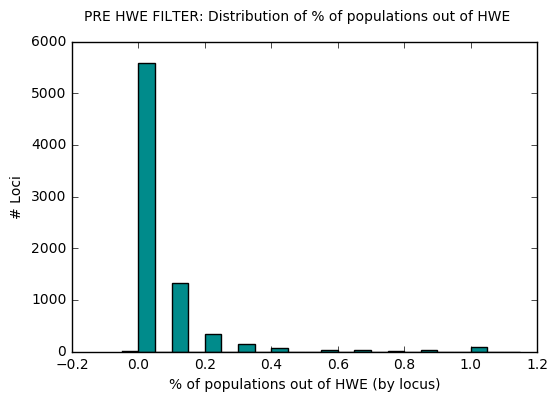

In [36]:
plt.hist(percents, bins = np.arange(-0.1, 1.1, .05)+0.05, color = "darkcyan")
plt.suptitle("PRE HWE FILTER: Distribution of % of populations out of HWE")
plt.xlabel("% of populations out of HWE (by locus)")
plt.ylabel("# Loci")
plt.show()

In [37]:
plt.close()

In [38]:
infile = open("batch_4_HWEpvals_filtered.txt", "r")

percents = []
loci_list = []
na_count = 0

for line in infile:
    if "locus" not in line:
        if line.strip().split()[10] != "NA":
            new_percent = float(line.strip().split()[10])
            percents.append(new_percent)
            loci_list.append(line.strip().split()[0])
        elif line.strip().split()[10] == "NA":
            na_count += 1

infile.close()

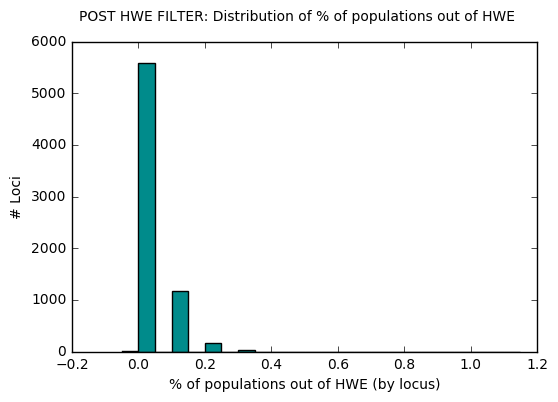

In [39]:
plt.hist(percents, bins = np.arange(-0.1, 1.1, .05)+0.05, color = "darkcyan")
plt.suptitle("POST HWE FILTER: Distribution of % of populations out of HWE")
plt.xlabel("% of populations out of HWE (by locus)")
plt.ylabel("# Loci")
plt.show()

In [40]:
plt.close()


<br>


### 6. Create new GENEPOP file with filtered loci. 

In [1]:
pwd

u'/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/notebooks'

In [2]:
cd ../analyses

/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/analyses


In [4]:
## STEP ONE: create a list of the loci to keep 
infile = open("batch_4_HWEpvals_filtered.txt", "r")

filtered_loci = []

for line in infile:
    if "locus" not in line:
        filtered_loci.append(line.strip().split()[0])

infile.close()

## STEP TWO: write out the genotypes for the loci to keep to a new genepop
## STEP THREE: write out the genotypes for loci out of HWE to different file
old_genepop = open("../batch_4_wgenome/batch_4.filteredMAF_filteredLoci_filteredIndivids.txt", "r")
new_genepop = open("../batch_4_wgenome/batch_4.filteredMAF_filteredLoci_filteredIndivids_filteredHWE.txt", "w")
bad_genepop = open("../batch_4_wgenome/batch_4.filteredMAF_filteredLoci_filteredIndivids_BADhwe.txt", "w")

for line in old_genepop:
    if line.startswith("sample"):
        new_genepop.write(line)
        bad_genepop.write(line)
    else: 
        locus_id = line.strip().split()[0]
        if locus_id in filtered_loci:
            new_genepop.write(line)
        else:
            bad_genepop.write(line)
old_genepop.close()
new_genepop.close()
bad_genepop.close()

In [7]:
## STEP FOUR: check to make sure only loci in HWE are now in genepop

print "There are ", len(filtered_loci), " loci in filtered list"

count = 0
good_filter = []
bad_filter = []
genepop = open("../batch_4_wgenome/batch_4.filteredMAF_filteredLoci_filteredIndivids_filteredHWE.txt", "r")
for line in genepop:
    if "sample" not in line:
        locus_id = line.strip().split()[0]
        count += 1
        if locus_id in filtered_loci:
            good_filter.append(locus_id)
        elif locus_id not in filtered_loci:
            bad_filter.append(locus_id)
genepop.close()

print "There are ", count, " loci in your filtered genepop file"
print len(bad_filter), " loci have not been filtered appropriately"
            

There are  6959  loci in filtered list
There are  6959  loci in your filtered genepop file
0  loci have not been filtered appropriately




<br>

For all data visualization and popgen analyses, I will be using the fully filtered file `batch_4.filteredMAF_filteredLoci_filteredIndivids_filteredHWE.txt`


<br>
### 7. Put fully filtered file in genepop format

In [8]:
cd ../scripts

/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/scripts


In [9]:
!python genepop_conversion_forR_fromTAB_b4.py \
../batch_4_wgenome/batch_4.filteredMAF_filteredLoci_filteredIndivids_filteredHWE.txt \
../batch_4_wgenome/batch_4.filteredMAF_filteredLoci_filteredIndivids_filteredHWE.gen

<br>
Fully filtered genepop file is: `../batch_4_wgenome/batch_4.filteredMAF_filteredLoci_filteredIndivids_filteredHWE.gen`